# Explainable AI con algoritmi genetici

In questo notebook si prova ad analizzare un possibile approccio genetico
a problemi di explainable AI, cercando di spiegare un classificatore **Random
Forest**. Non ci interessa sapere se la classificazione sia corretta o meno ma
solo:

- "Perché" i dati sono stati classificati in quel modo dal modello.
- Come modificare i dati in modo che varino il meno possibile ma vengano
  classificati in modo differente.

Prendiamo come riferimento un problema semplice in cui abbiamo punti definiti
da 2 sole feature e che possono essere classificati in soli 2 modi.

## Roadmap

Iniziamo con il definire ad alto livello l'algoritmo completo:

1. Training di un modello di classificazione Random Forest o MLP.
2. Classificazione di punti non presenti nel training set.
3. Esecuzione dell'algoritmo genetico su ogni punto classificato.
4. Analisi dei fattuali cercando un grado di incertezza nella classificazione.
5. Analisi dei controfattuali valutando quanti individui sintetici sono
   riusciti a cambiare classe e, nel caso ci siano riusciti, misurazione della
   differenza nel valore delle feature.


In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification


X, y = make_classification(
    n_samples=200,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=1,
    shuffle=True,
    random_state=0,
)

df = pd.DataFrame({"feature1": X.T[0], "feature2": X.T[1], "class": y})
df

,feature1,feature2,class
0,1.070334,-0.929154,1
1,-0.475656,1.278883,0
2,0.885906,1.690195,1
3,1.365818,1.077153,1
4,-1.260713,0.895089,0
...,...,...,...
195,0.858270,2.063549,1
196,0.628935,2.615793,1
197,0.359017,-1.073006,1
198,-0.521872,0.578906,0


Proseguiamo con il dividere il dataset in training set e test set. Di seguito
un plot del training set.


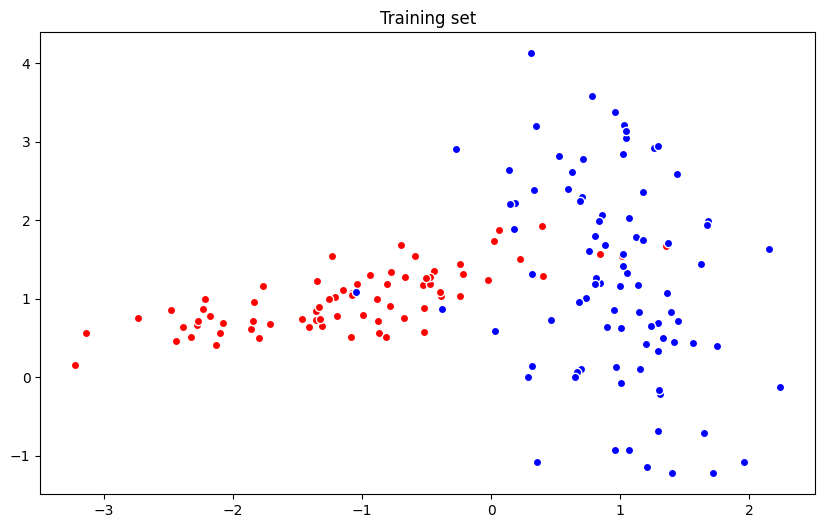

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

cls0 = [i for i in range(len(y_train)) if y_train[i] == 0]
cls1 = [i for i in range(len(y_train)) if y_train[i] == 1]

cmap = plt.get_cmap("Set1")
plt.figure(figsize=(10, 6))
plt.title("Training set")
plt.scatter(X_train.T[0][cls0], X_train.T[1][cls0], c="r", ec="w")
plt.scatter(X_train.T[0][cls1], X_train.T[1][cls1], c="b", ec="w")
plt.show()

Abbiamo quindi un training set e un test set su cui allenare e testare il
modello rispettivamente. Più precisamente non sfrutteremo la parte di test set
che ci fornisce la classe giusta per i punti classificati. Non è di nostro
interesse infatti testare la correttezza del modello.

Proseguiamo quindi con l'allenamento del modello e la classificazione dei nuovi
punti i quali diventeranno centrali nella nostra analisi.


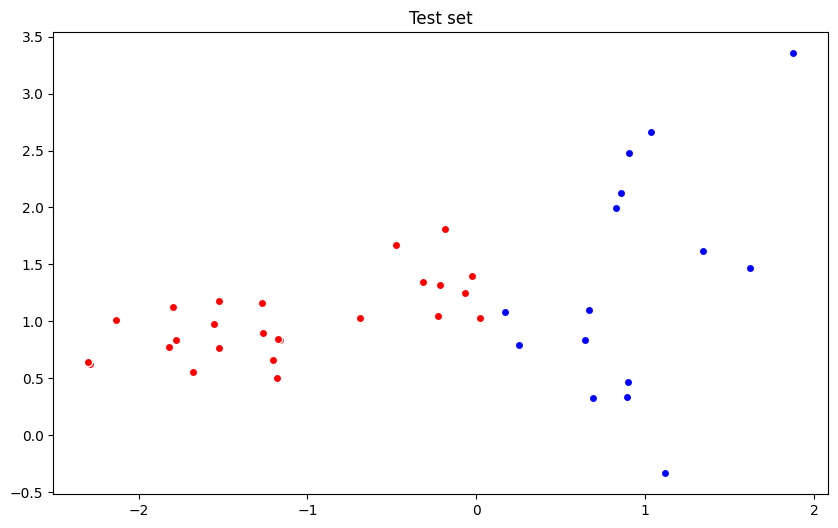

In [3]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
y_predicted = classifier.predict(X_test)

cls0 = [i for i in range(len(y_predicted)) if y_predicted[i] == 0]
cls1 = [i for i in range(len(y_predicted)) if y_predicted[i] == 1]

plt.figure(figsize=(10, 6))
plt.title("Test set")
plt.scatter(X_test[cls0].T[0], X_test[cls0].T[1], c="r", ec="w")
plt.scatter(X_test[cls1].T[0], X_test[cls1].T[1], c="b", ec="w")
plt.show()

A questo punto prendiamo a caso uno dei punti classificati, di seguito
rappresentato con una X.


point: (0.17047, 1.08044)
class: 1


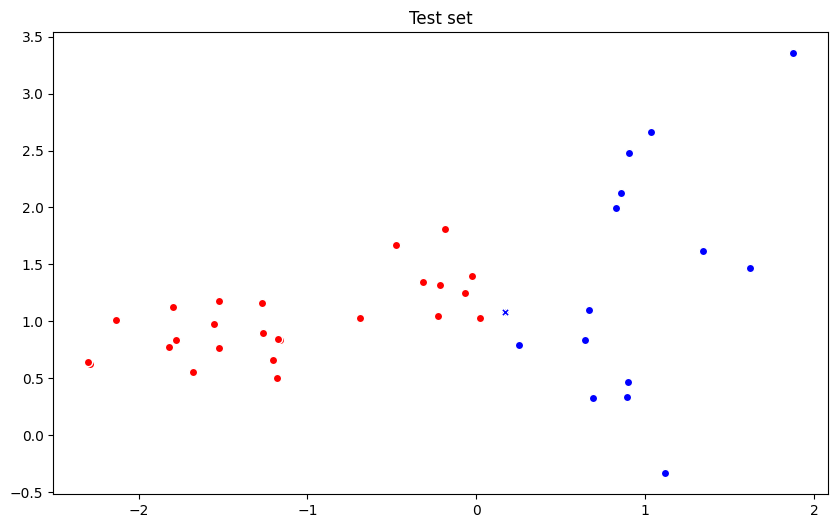

In [4]:
plt.figure(figsize=(10, 6))
plt.title("Test set")
plt.scatter(X_test[cls0].T[0], X_test[cls0].T[1], c="r", ec="w")
plt.scatter(X_test[cls1].T[0], X_test[cls1].T[1], c="b", ec="w")

point = X_test[7]
print(f"point: ({point[0]:.5f}, {point[1]:.5f})")
point_class = y_predicted[7]
print(f"class: {point_class}")

c = "r" if point_class == 0 else "b"
plt.scatter(point[0], point[1], c=c, ec="w", marker="X")
plt.show()

## Algoritmo genetico

L'algoritmo genetico prevede di analizzare ogni singolo punto un numero di
volte pari al numero delle classi possibili (nel nostro caso 2). Andremo a
definire due approcci volti a risolvere due problemi differenti:

1. Spiegare perché quel punto è stato classificato in un determinato modo.
2. Capire come modificare le feature di quel punto il meno possibile per
   riuscire a classificarlo in tutte le altre possibili classi.

Come forma del cromosoma abbiamo semplicemente il vettore delle feature di
ciascun individuo.

### Generazione della popolazione iniziale

Come in ogni algoritmo genetico c'è bisogno di andare a generare una
popolazione iniziale. Nel nostro caso abbiamo bisogno che la popolazione
iniziale sia generata in modo che i nuovi individui siano simili a quello di
riferimento.

Per riuscire a generare una popolazione con queste caratteristiche possiamo
sfruttare la deviazione standard di ogni feature per generare un offset
coerente con il dataset che stiamo considerando su ogni asse.


In [5]:
sigma = X_test.std(axis=0)
sigma

array([1.17144131, 0.6751292 ])

Per generare punti sintetici intorno a quello di riferimento usiamo due
possibili distribuzioni

- **Uniforme**: si ottiene una popolazione sintetica equamente distribuita su
  ogni asse sfruttando un parametro $\alpha \in [0, 1]$ per regolare l'ampiezza
  dell'intervallo di valori. Intervallo definito in funzione della deviazione
  standard di ognuna delle feature. Avremo quindi che per ogni feature, lo
  spazio entro cui vengono generate le feature dei punti sintetici è il
  seguente
  $$[x_i - \sigma_i \cdot \alpha, \; x_ i + \sigma_i \cdot \alpha]$$
  dove $x_i$ è il valore dell'$i$-esima feature per il punto $x$ e $\sigma_i$ è
  la deviazione standard dell'$i$-esima feature rispetto a tutta la popolazione.
- **Normale**: in modo simile possiamo usare una distribuzione normale centrata
  nel valore della feature e usare sempre una frazione della deviazione
  standard piccola a piacere. Avremo quindi una distribuzione del tipo:
  $$N(x_i, \; \sigma_i \cdot \alpha)$$
  in cui $x_i$ è il valore dell'$i$-esima feature e $\sigma_i$ la sua
  deviazione standard.

Una distribuzione normale dovrebbe avere il vantaggio di riuscire a scalare
con la stessa dispersione che ha popolazione intera, mantenendo le
caratteristiche delle distribuzione di punti iniziale.

Una distribuzione uniforme invece riempe uno spazio arbitrariamente grande e
ben definito intorno al punto di riferimento. Potrebbe però non rispecchiare
la distribuzione dei punti del dataset di riferimento. Lo spazio entro il quale
vengono generati i punti tenderà inoltre ad avere una forma rettangolare se si
genera un numero sufficiente di punti.


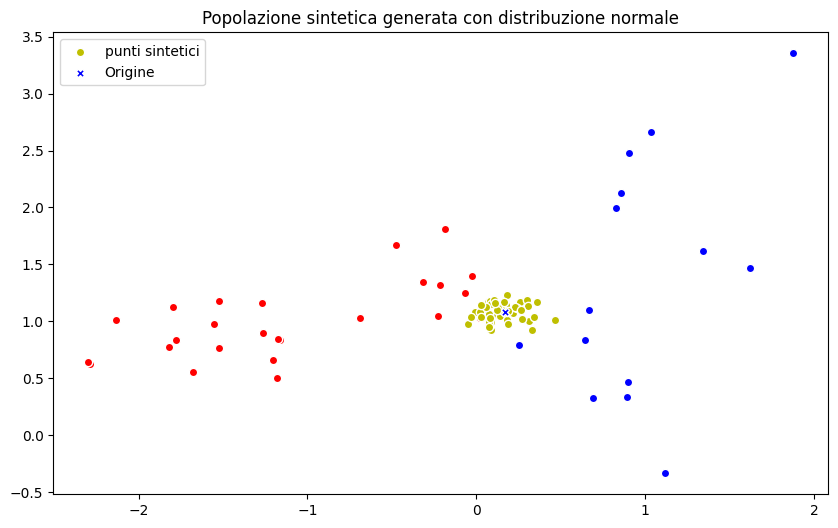

In [6]:
from numpy import random
from ppga import base


def generate_normal(point, sigma, alpha: float) -> np.ndarray:
    return random.normal(point, alpha * sigma, size=(2,))


def generate_uniform(point, sigma, alpha: float) -> np.ndarray:
    return random.uniform(point - sigma * alpha, point + sigma * alpha, size=(2,))


toolbox = base.ToolBox()
toolbox.set_generation(generate_normal, point=point, sigma=sigma, alpha=0.1)

# generazione di una popolazione composta da 50 individui
population = toolbox.generate(50)
synth_points = np.array([i.chromosome for i in population])

plt.figure(figsize=(10, 6))
plt.title("Popolazione sintetica generata con distribuzione normale")
plt.scatter(X_test[cls0].T[0], X_test[cls0].T[1], c="r", ec="w")
plt.scatter(X_test[cls1].T[0], X_test[cls1].T[1], c="b", ec="w")

plt.scatter(
    synth_points.T[0], synth_points.T[1], c="y", ec="w", label="punti sintetici"
)

c = "r" if point_class == 0 else "b"
plt.scatter(point[0], point[1], c=c, ec="w", marker="X", label="Origine")

plt.legend()
plt.show()

### Funzione di valutazione

La funzione di valutazione è certamente uno dei punti più importanti. Nello ci
serviranno due funzioni differenti:

- La prima funzione ci serve nel caso in cui si voglia rimanere nella stessa
  classe del punto di riferimento.
- La seconda funzione ci serve invece quando si vuole cambiare la classe dei
  punti sintetici in una classe specifica, diversa da quella di partenza.

Il valore di fitness in sé viene invece dato dalla **distanza euclidea** tra i
due punti. Distanza che siamo sempre interessati a minimizzare. Ovviamente
minimizzare la distanza e basta porterebbe tutti i punti a sovrapporsi
inevitabilmente al punto di partenza. Situazione decisamente poco informativa.

Per risolvere il problema è necessario implementare entrambe le funzioni in
modo tale da far allontanare i punti sintetici dal punto d'origine fin tanto
che non si verifica una certa condizione:

- Nel primo caso abbiamo funzione che minimizza la distanza dei punti sintetici
  dal punto d'origine.
- Nel secondo caso abbiamo invece una funzione che fa allontanare i punti
  sintetici finché non sono classificati nella classe obbiettivo.

#### Stessa classe

L'obbiettivo della prima funzione di valutazione sarebbe quello di trovare
punti con una classificazione incerta. Se minimizzando la distanza si hanno
alcuni punti sintetici che sono valutati diversamente da come è valutato il
punto d'origine, significa che ci troviamo in una zona _incerta_.

In questo caso si potrebbe misurare il grado di incertezza del modello andando
a vedere, il rapporto tra i punti sintetici classificati diversamente dal punto
d'origine e quelli classificati come quest'ultimo.

Ovviamente nel caso tutti i punti siano classificati allo stesso modo del punto
d'origine ci si può ritenere in una zona _sicura_, in cui il modello più 
difficilmente riuscirà a cambiare la scelta che ha fatto.

##### Criticità

In questo caso vogliamo definire una funzione che minimizzi la distanza andando
a premiare gli individui classificati come il punto d'origine.

Dobbiamo però stare attenti a definire correttamente un qualche $\epsilon$ per
evitare che ci sia una completa sovrapposizione dei punti sintetici con il 
punto d'origine. Situazione che non ci porterebbe alcuna informazione.

Per riuscire a definire tale valore possiamo usare un metodo simile a quello
usato per la generazione. Possiamo infatti far sì che ogni punto sintetico
non si avvicini più di una frazione della deviazione standard globale.

In questo modo il valore $\epsilon$ cambia dinamicamente in funzione sia
dell'ordine di grandezza delle feature, sia della loro dispersione.

La differenza rispetto alla generazione dei punti sintetici è che non possiamo
considerare una deviazione standard separata per ogni feature dato che la
distanza è monodimensionale. Dobbiamo quindi calcolare la norma della
deviazione standard per ottenere un valore monodimensionale comparabile.


In [7]:
from numpy import linalg


def same_evaluate(chromosome, point, classifier, sigma, eps=0.02, alpha=0.8):
    assert eps >= 0.0 and eps <= 1.0
    assert alpha >= 0.0 and alpha < 1.0

    # classification
    pt_class = classifier.predict(point.reshape(1, -1))
    synth_class = classifier.predict(chromosome.reshape(1, -1))

    # compute epsilon for too similar points
    epsilon = linalg.norm(sigma * eps, ord=2)

    # calcolo della distanza con norma euclidea
    distance = linalg.norm(chromosome - point, ord=2)
    if distance <= epsilon:
        # print(f"{distance}, {epsilon}")
        distance = distance + epsilon

    # compute classification penalty
    same_class = 1 - alpha if pt_class == synth_class else alpha

    return (same_class * distance,)


toolbox.set_weights((-1.0,))
toolbox.set_evaluation(same_evaluate, point, classifier, sigma, 0.02, 0.8)
population = list(map(toolbox.evaluate, population))

La funzione, oltre quindi a parametri come il punto di riferimento e il 
classificatore, ha bisogno di 3 parametri:

- `sigma`: deviazione standard della popolazione.
- `eps`: coefficiente compreso tra 0 e 1 per calcolare l'epsilon che penalizza
  i punti che si avvicinano troppo al punto d'origine.
- `alpha`: coefficiente di penalità compreso tra 0 e 1 ma che dovrebbe sempre
  essere maggiore di 0.5 per ottenere il comportamento sperato.

Il coefficiente di penalità, che di default ha valore $0.8$ penalizza i punti
classificati diversamente dal punto d'origine moltiplicando la loro distanza
per $1 - \alpha$. In questo modo, tali punti risultano molto più lontani di 
quanto lo siano realmente e ricevono un valore di fitness più basso.

Se invece il punto sintetico viene classificato come quello d'origine, la sua 
distanza viene moltiplicata per $\alpha$ stesso. Anche in questo caso il punto
riceve una penalità ma, per valori di $\alpha$ maggiori di $0.5$, a parità di 
distanza verranno sempre penalizzati di più il punti classificati diversamente
dal punto d'origine.


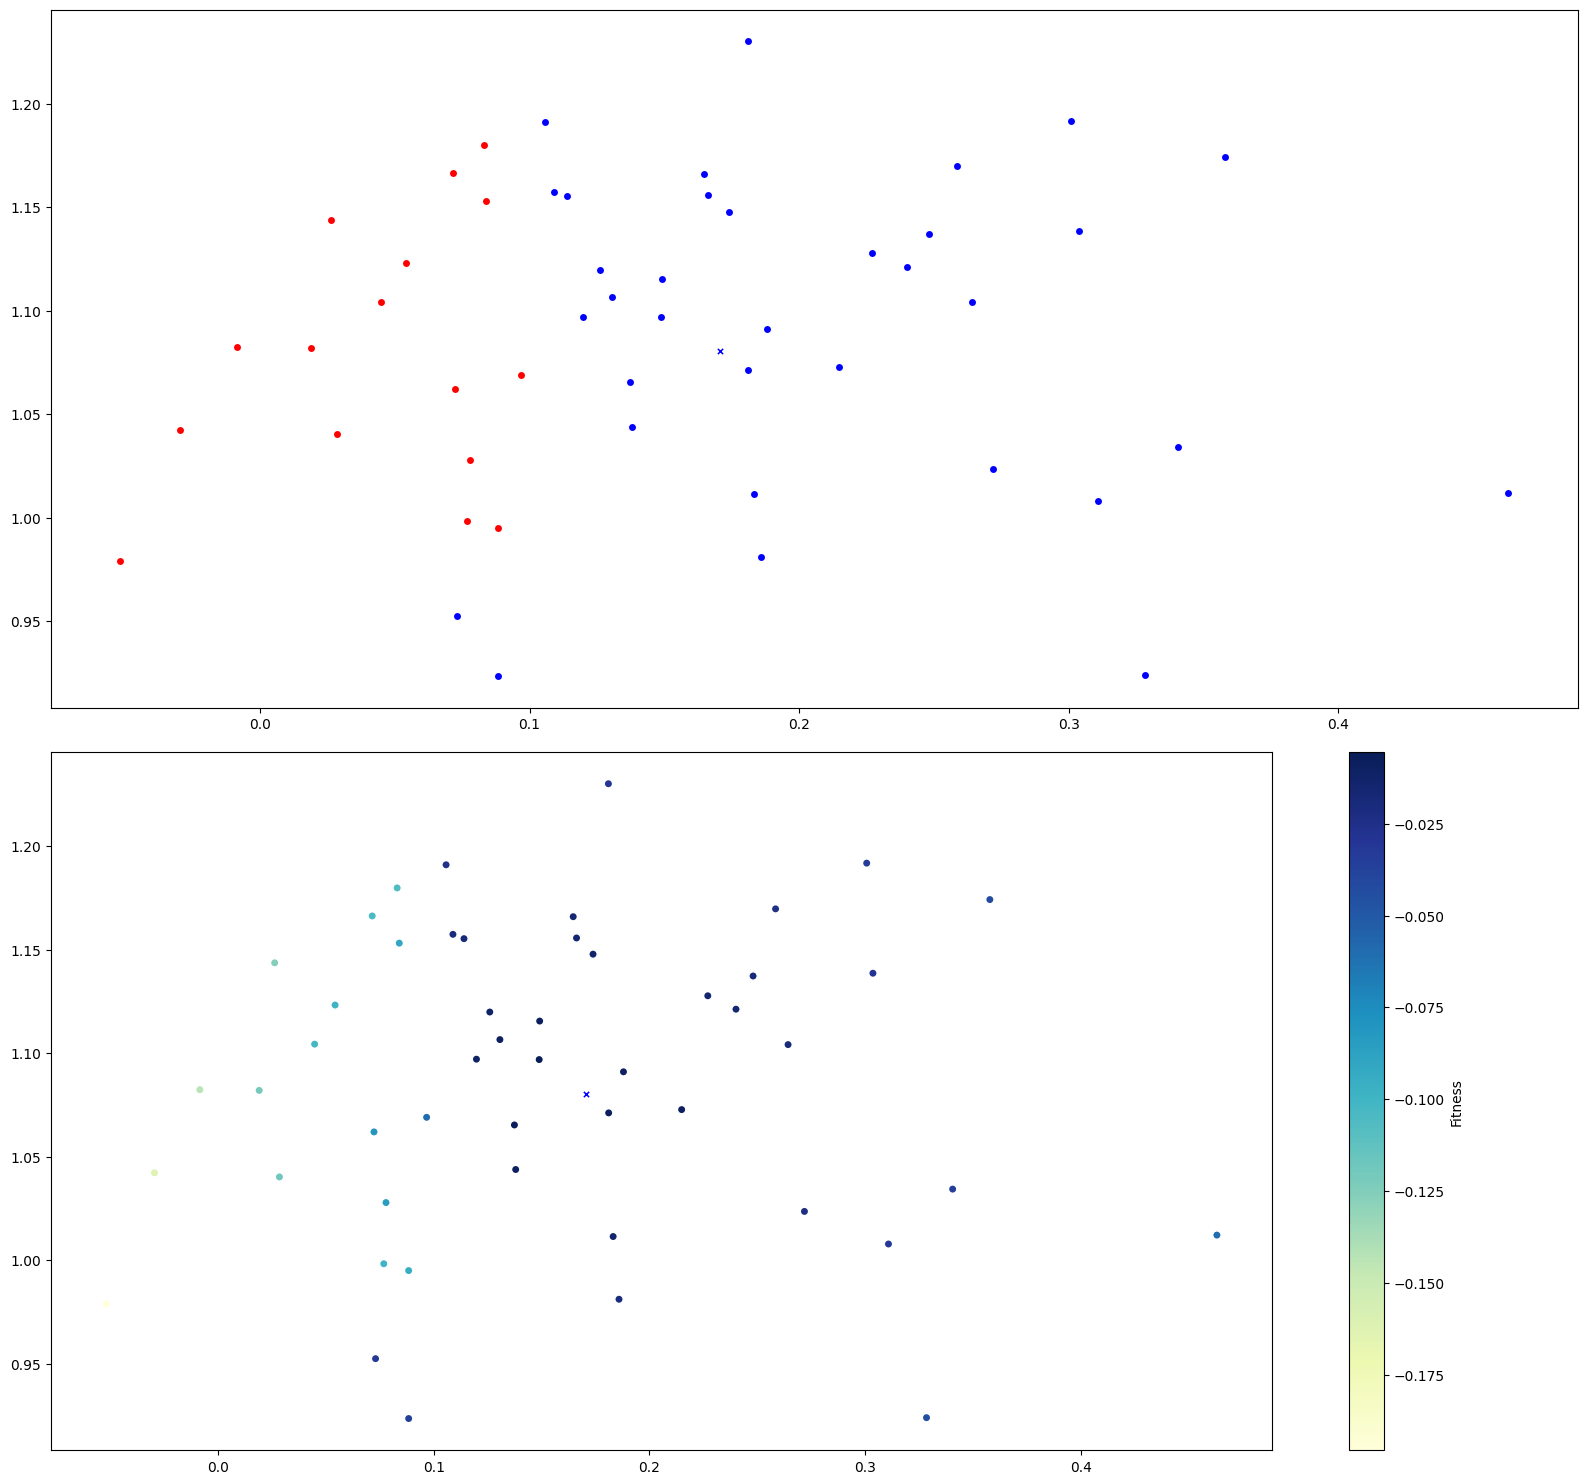

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 15))
plt.tight_layout()

synth_classes = [classifier.predict(sp.reshape(1, -1)) for sp in synth_points]

scls0 = [i for i in range(len(synth_classes)) if synth_classes[i] == 0]
scls1 = [i for i in range(len(synth_classes)) if synth_classes[i] == 1]

# classification plot
ax1.scatter(synth_points[scls0].T[0], synth_points[scls0].T[1], c="r", ec="w")
ax1.scatter(synth_points[scls1].T[0], synth_points[scls1].T[1], c="b", ec="w")
ax1.scatter(point[0], point[1], c=c, ec="w", marker="X")

# fitness plot
fitness_values = [i.fitness for i in population]
sc = ax2.scatter(
    synth_points.T[0],
    synth_points.T[1],
    c=fitness_values,
    ec="w",
    cmap=plt.get_cmap("YlGnBu"),
)
fig.colorbar(sc, ax=ax2, label="Fitness")
ax2.scatter(point[0], point[1], c=c, ec="w", marker="X")

plt.show()

Almeno visivamente dovrebbe essere possibile notare come, a parità di distanza
dal punto d'origine, i punti classificati diversamente dal punto d'origine,
abbiano un valore di fitness più basso.


#### Cambio di classe

Quando si vuole invece cambiare la classe 
Andiamo ora a costruire una funzione di fitness di modo da premiare gli
individui che riescono ad essere classificati in una classe target differente
da quella di partenza.

In questo caso abbiamo una funzione con un comportamento leggermente differente:

$$
f(x_i) = \begin{cases}
    1 - d(x_0, x_i) & \text{se } C_i \neq C_t \\
    d(x_0, x_i) & \text{altrimenti}
\end{cases}
$$

dove $C_t$ è la classe target a cui stiamo cercando di arrivare.


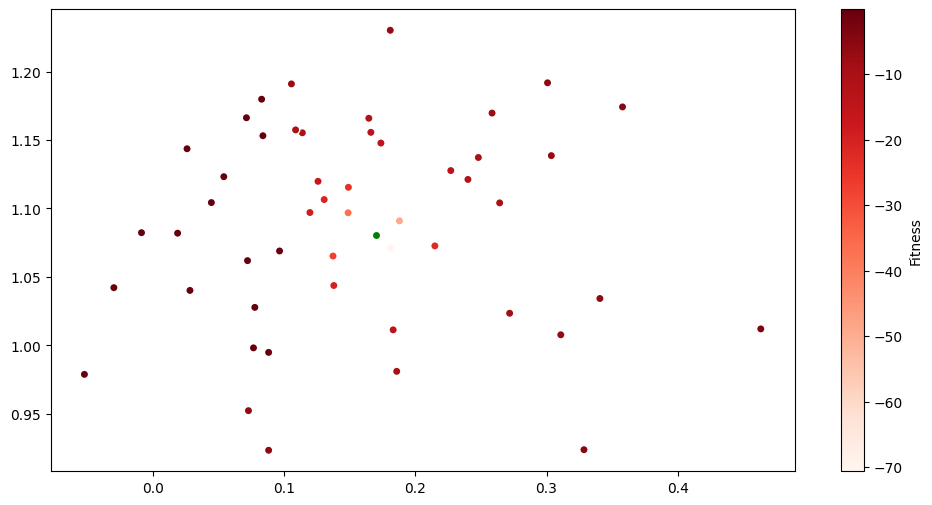

In [9]:
def other_evaluate(chromosome, point, classifier, target):
    # classification
    synth_class = classifier.predict(chromosome.reshape(1, -1))

    # calcolo della distanza con norma euclidea
    distance = linalg.norm(point - chromosome, ord=2)

    if target == synth_class:
        return (distance,)
    else:
        return (1 / distance,)


toolbox.set_weights((-1.0,))
toolbox.set_evaluation(other_evaluate, point, classifier, (point_class + 1) % 2)
population = list(map(toolbox.evaluate, population))

fitness_values = [i.fitness for i in population]
plt.figure(figsize=(12, 6))
sc = plt.scatter(
    synth_points.T[0],
    synth_points.T[1],
    c=fitness_values,
    ec="w",
    cmap=plt.get_cmap("Reds"),
)
plt.colorbar(sc, label="Fitness")
plt.scatter(point[0], point[1], c="g", ec="w")
plt.show()

### Crossover

Gli operatori di crossover da testare sono principalmente due:

- **One point** o **Two Points**: questi due operatori andrebbero a mischiare
  le feature dei due individui lasciandole invariate, sarà poi compito
  dell'operatore di mutazione effettuare variazioni sui valori stessi.
- **Media e fattore stocastico**: in alternativa si potrebbero creare due figli
  le cui feature sono la media delle feature dei genitori. Dato che sarebbero
  due figli uguali si potrebbe aggiungere un termine casuale per differenziarli.
  In alternativa si potrebbe generare un solo figlio da ogni coppia.

Per i test andremo ad usare un semplice _one point crossover_.


In [10]:
def cx_one_point(father, mother):
    cx_point = random.randint(1, len(father))

    offspring1 = np.append(father[:cx_point], mother[cx_point:])
    offspring2 = np.append(mother[:cx_point], father[cx_point:])

    return offspring1, offspring2


toolbox.set_crossover(cx_one_point)
o1, o2 = toolbox.crossover(population[0], population[1])
print(f"father: {population[0].chromosome}")
print(f"mother: {population[1].chromosome}")
print(f"offspring 1: {o1.chromosome}")
print(f"offspring 2: {o2.chromosome}")

father: [0.13738448 1.06524451]
mother: [0.16619796 1.15558395]
offspring 1: [0.13738448 1.15558395]
offspring 2: [0.16619796 1.06524451]


Come possiamo vedere con due features andiamo semplicemente ad incrociare i
valori di padre e madre per generare due figli. Il problema di questo crossover
è che da solo non genera mai nuovi valori per le feature ma va ad esplorare
le possibili permutazioni dei valori già esistenti.

### Mutazione

L'operatore di mutazione andrà a modificare ogni feature di un termine
stocastico con una certa probabilità. Tale termine viene generato casualmente
tramite una distribuzione gaussiana
$$N(x_i, \; \alpha \cdot \sigma_i)$$
centrata nel valore della feature $i$-esima ($x_i$) e con deviazione standard
una frazione ($\alpha$) della deviazione standard di quella feature calcolata
sull'intera popolazione ($\sigma_i$).


In [11]:
def mut_gaussian(individual, sigma, alpha: float = 0.05, indpb: float = 0.2):
    for i, f in enumerate(individual):
        if random.random() <= indpb:
            individual[i] = random.normal(loc=f, scale=sigma[i] * alpha)

    return individual


toolbox.set_mutation(mut_gaussian, sigma, 0.1, 0.8)
print(o1)
o1 = toolbox.mutate(o1)
print(o1)

[0.13738448 1.15558395]: 0.0
[0.10800939 1.12046028]: 0.0


L'operatore richiede quindi la deviazione standard di tutte le feature calcolata
sull'intera popolazione, un parametro $\alpha$ che regola l'intesità della
mutazione e la probabilità che ogni singola feature ha di essere mutata.


### Simulazione

Proviamo quindi ad effettuare una simulazione provando a capire quale sia il
modo migliore di far cambiare classe al punto in questione.

Di seguito è possibile vedere la i migliori individui della popolazione
sintetica finale, tutti raccolti nella _Hall of Fame_ generazione dopo
generazione.


[INFO] CORE: 	gen            mean evals/worker
[INFO] CORE: 	0              4.000000       
[INFO] CORE: 	1              2.571429       
[INFO] CORE: 	2              3.000000       
[INFO] CORE: 	3              3.285714       
[INFO] CORE: 	4              3.285714       
[INFO] CORE: 	5              3.571429       
[INFO] CORE: 	6              3.000000       
[INFO] CORE: 	7              3.428571       
[INFO] CORE: 	8              3.285714       
[INFO] CORE: 	9              3.428571       
[INFO] CORE: 	10             2.857143       
[INFO] CORE: 	11             3.428571       
[INFO] CORE: 	12             3.428571       
[INFO] CORE: 	13             3.142857       
[INFO] CORE: 	14             3.571429       
[INFO] CORE: 	15             2.714286       
[INFO] CORE: 	16             3.714286       
[INFO] CORE: 	17             3.285714       
[INFO] CORE: 	18             3.142857       
[INFO] CORE: 	19             3.428571       
[INFO] CORE: 	20             3.142857       
[INFO] C

NameError: name 'test_coords' is not defined

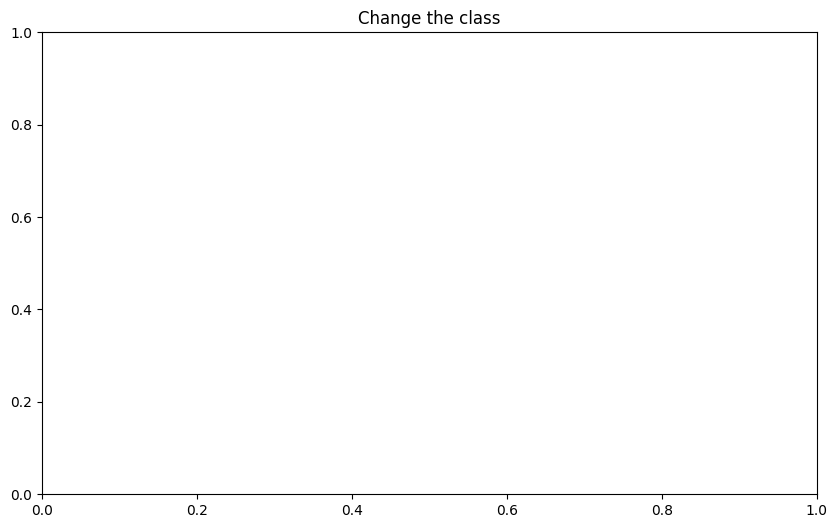

In [12]:
from ppga import tools, algorithms, log

toolbox.set_selection(tools.sel_tournament, tournsize=3)

hof = base.HallOfFame(20)
population, stats = algorithms.pelitist(
    toolbox=toolbox,
    population_size=50,
    keep=0.3,
    cxpb=0.8,
    mutpb=0.2,
    max_generations=50,
    hall_of_fame=hof,
    log_level=log.INFO
)

synth_points = np.array([i.chromosome for i in hof])

plt.figure(figsize=(10, 6))
plt.title("Change the class")
plt.scatter(test_coords[0], test_coords[1], c=y_predicted, ec="w")
plt.scatter(
    synth_points.T[0], synth_points.T[1], c="y", ec="w", label="synthetic points"
)
plt.scatter(point[0], point[1], c="g", ec="w", label="start point")

plt.legend()
plt.show()

Come si può vedere, i punti sintetici si schiacciano sul confine tra una classe
e l'altra.

### Analisi

Il prossimo passo è quello di andare a comparare le feature del punto originale
con quelle dei punti sintetici che sono riusciti a cambiare classe. In questo
modo è possibile _spiegare_ come far cambiare classe ad un determinato punto.


In [ ]:
hof = list(
    filter(
        lambda x: classifier.predict(np.asarray(x.chromosome).reshape(1, -1))
        != point_class,
        hof.hof,
    )
)
print(f"best synth points: {len(hof)}")
for i in hof:
    print(f"{i} | class: {classifier.predict(np.asarray(i.chromosome).reshape(1, -1))}")

d1 = linalg.norm(hof[-1].chromosome[0] - point[0])
d2 = linalg.norm(hof[-1].chromosome[1] - point[1])

In [ ]:
print(d1)
print(d2)